In [3]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import random
import requests
from PIL import Image
import io

In [4]:
def read_dataset(filename="updated_dataset.json"):
    with open(filename, "r") as f:
        return json.load(f)

In [5]:
dataset = read_dataset()

In [6]:
import datetime
# Load the data into a DataFrame
data = pd.DataFrame.from_dict(dataset, orient='index')

data['post_count'] = data['posts'].apply(lambda x: len(x))
data['post_dates'] = data['posts'].apply(lambda x: [datetime.datetime.strptime(
    post['timestamp'], "%Y-%m-%dT%H:%M:%S%z").date() for post in x.values()])
data.drop(columns=['posts'], inplace=True)

# drop profile picture
data = data.drop(columns=['profile_picture_url'])

print(", ".join(data.columns))


name, biography, followers_count, follows_count, media_count, id, business_category_name, interests, post_count, post_dates


In [7]:
def post_date(data):
    dates_list = []
    years = {}
    for dates in data:
        for date in dates:
            dates_list.append(date)
            if date.year in years:
                years[date.year] += 1
            else:
                years[date.year] = 1
    total_days = sum(dt.toordinal() for dt in dates_list)
    average_date = datetime.date.fromordinal((total_days // len(dates_list)))
    return min(dates_list), max(dates_list), years, average_date


oldest, newest, posts_per_year, avg_date = post_date(data['post_dates'])
# Some stats
stats = pd.DataFrame({
    'Total number of users': [len(data)],
    'Number of users with posts': [len(data[data['post_count'] > 0])],
    'Number of users with no posts': [len(data[data['post_count'] == 0])],
    'Max number of posts': [data['post_count'].max().astype(int)],
    'Min number of posts': [data['post_count'].min().astype(int)],
    'Mean number of posts': [data['post_count'].mean().astype(int)],
    'Total number of posts': [data['post_count'].sum().astype(int)],
    'oldest post': [oldest],
    'newest post': [newest],
    'average post date': [avg_date],
}).transpose()
# remove header
stats.columns = ['']

# render
stats


,
Total number of users,264
Number of users with posts,264
Number of users with no posts,0
Max number of posts,500
Min number of posts,1
Mean number of posts,155
Total number of posts,41130
oldest post,2013-06-21
newest post,2023-03-24
average post date,2021-07-06


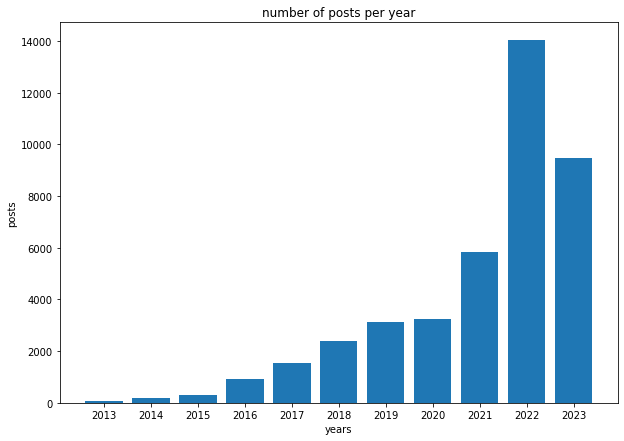

In [8]:
x_values = list(posts_per_year.keys())
y_values = list(posts_per_year.values())

fig = plt.figure(figsize=(10, 7))

# Create a bar plot
plt.bar(x_values, y_values)

plt.xticks(x_values)
# Add labels and title
plt.xlabel('years')
plt.ylabel('posts')
plt.title('number of posts per year')

# Show the plot
plt.show()


In [12]:
# Make a set for interests
interests = set()

for i in data['interests']:
    i = i.replace(", ", ",").split(",")
    for interest in i:
        interests.add(interest)
interests = list(interests)
interests.sort()
print(interests)
print("Number of interests: {}".format(len(interests)))

['Adventure', 'Architecture', 'Arts and music', 'Books', 'Business', 'Design', 'Drawing', 'Entertainment', 'Family and relationships', 'Fitness and wellness', 'Food and drink', 'Home and garden', 'Nature', 'News', 'Online', 'Outdoor recreation', 'Painting', 'Pets', 'Photography', 'Politics and social issues', 'Sculpture', 'Shopping and fashion', 'Sports', 'Technology', 'Travel', 'Vehicles']
Number of interests: 26


Vehicles


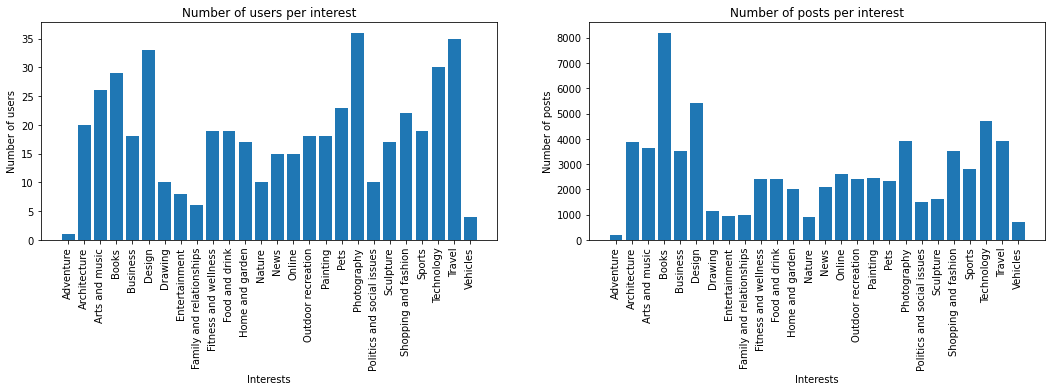

In [10]:
# Make a graph for the number of posts per interest
posts_count = []
for interest in interests:
    posts_count.append(data[data['interests'].str.contains(interest)]['post_count'].sum())

# Make a graph of the number of users per interest 
users_count = []
for interest in interests:
    users_count.append(len(data[data['interests'].str.contains(interest)]))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 4))
print(interest)
# plot the graph with labels
ax1.bar(interests, users_count)
ax1.set_xticks(range(len(interests)))
ax1.set_xticklabels(interests, rotation=90)
ax1.set_xlabel("Interests")
ax1.set_ylabel("Number of users")
ax1.set_title("Number of users per interest")

# plot the graph with labels
ax2.bar(interests, posts_count)
ax2.set_xticks(range(len(interests)))
ax2.set_xticklabels(interests, rotation=90)
ax2.set_xlabel("Interests")
ax2.set_ylabel("Number of posts")
ax2.set_title("Number of posts per interest");

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x000001F1935448B0>

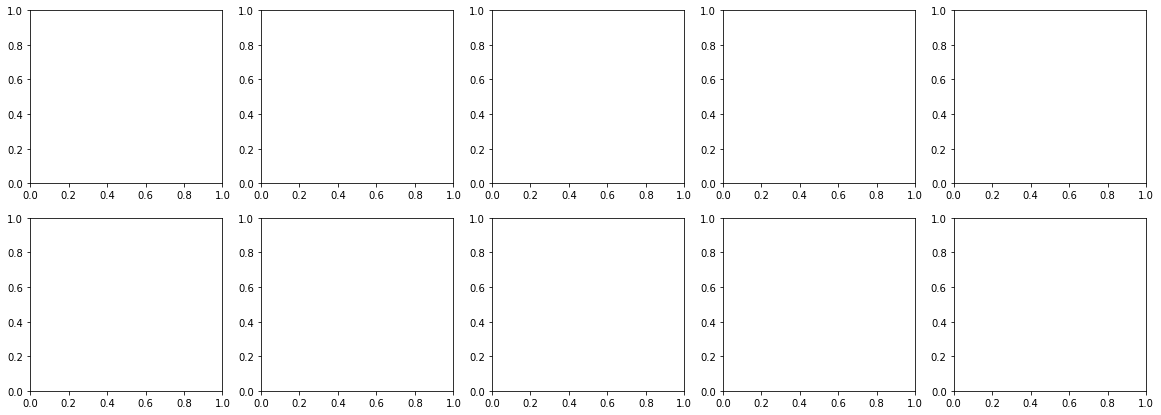

In [11]:
# Display some random posts photos in matplotlib
def display_random_posts(dataset, n=4, interest=None):
    if interest is not None:
        dataset = {k: v for k, v in dataset.items() if interest.lower()
                   in v['interests'].lower()}
    else:
        dataset = dataset
    fig, ax = plt.subplots(2, n, figsize=(20, 7))
    i = 0
    while i < n * 2:
        user = random.choice(list(dataset.keys()))
        post = random.choice(list(dataset[user]['posts'].keys()))
        media_url = dataset[user]["posts"][post].get('media_url', None)
        if media_url is None or dataset[user]["posts"][post]['media_type'] == 'VIDEO':
            continue
        response = requests.get(media_url)
        img = response.content
        img = Image.open(io.BytesIO(img))
        ax[i // n, i % n].imshow(img)
        ax[i // n, i % n].axis('off')
        ax[i // n, i % n].set_title(dataset[user]['interests'], fontsize=10)
        i += 1

    plt.show()


display_random_posts(dataset, n=5, interest="photography")
